In [3]:
import numpy as np
from numpy.random import dirichlet, multinomial
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

"""
A toy experiment with a synthetically generated typical set of datasets.
"""


class SyntheticAnnotation:
    def __init__(
        self,
        size_of_dataset,
        number_of_datasets,
        inner_sample_size,
        outer_sample_size,
        alpha,
        beta,
        epsilon=0.02,
    ):
        self.epsilon = epsilon  # inequality epsilon
        self.number_of_datasets = (
            number_of_datasets  # number of datasets we sample from
        )
        self.size_of_dataset = (
            size_of_dataset  # number of datapoints in a dataset we sample from
        )

        self.outer_sample_size = (
            outer_sample_size  # number of times we sample a dataset
        )
        self.inner_sample_size = (
            inner_sample_size  # number of times we sample from the dataset
        )
        self.alpha = alpha  # sampling temperature for outer samples
        self.beta = beta  # sampling temperature for inner samples

        self.a = np.ones(self.size_of_dataset)  # instantiate a sample dataset
        self.p_datapoint = dirichlet(
            self.alpha * self.a
        )  # probability of a datapoint in every dataset
        self.mean_p_datapoint = np.mean(
            self.p_datapoint
        )  # mean probability of a datapoint in every dataset

        (
            self.typical_samples,
            self.typical_labels,
            self.rest_samples,
            self.rest_labels,
        ) = ([], [], [], [])

    def sample_outer(self):
        results = []
        all_mean_samples, all_mean_labels = [], []
        for _ in range(self.outer_sample_size):
            data_samples, data_labels = self.sample_inner()
            mean_data_sample = np.mean(data_samples)
            mean_data_label = np.mean(data_labels)
            results.append((mean_data_sample, mean_data_label))
            all_mean_samples.append(mean_data_sample)
            all_mean_labels.append(mean_data_label)

        return all_mean_samples, all_mean_labels

    def sample_inner(self):
        """
        Generates a pairs of string probability and human judgement.
        """
        dataset = multinomial(self.size_of_dataset, pvals=self.p_datapoint)
        samples = {}

        data_samples, data_labels = [], []
        for i in range(self.inner_sample_size):
            samples[i] = dataset[i]

        for sample in samples:
            pvals = self.get_p_sample(sample)
            annotations = multinomial(
                samples[sample], pvals=pvals
            )  # pval of label == p_sample
            for _ in range(annotations[0]):
                data_samples.append(-np.log(self.p_datapoint[sample]))
                data_labels.append(-np.log(pvals[0]))

        return data_samples, data_labels

    def get_p_sample(self, sample):
        """
        Returns a probaility of a sample datapoint.
        """
        w = np.exp(self.beta * (self.p_datapoint[sample] - self.mean_p_datapoint))
        Z = 1.0 + w
        return np.asarray([w / Z, 1 / Z])

    def run_experiment(self):
        all_mean_samples, all_mean_labels = self.sample_outer()
        summary = []
        count = 0
        for sample, label in zip(all_mean_samples, all_mean_labels):
            if (
                np.abs(
                    sample
                    + label
                    - np.mean(all_mean_samples)
                    - np.mean(all_mean_labels)
                )
                < self.epsilon
            ):
                count += 1
                summary.append((sample, label))
                self.typical_samples.append(sample)
                self.typical_labels.append(label)
            else:
                self.rest_samples.append(sample)
                self.rest_labels.append(label)

        print(
            "Typical Set Correlation Probability/Label: ",
            spearmanr(list(zip(*summary))[0], list(zip(*summary))[1]),
        )
        print("Typical Set Size: ", count)

    def visualise(self):
        plt.scatter(self.rest_samples, self.rest_labels)
        plt.scatter(self.typical_samples, self.typical_labels, color="red")
        plt.show()

Typical Set Correlation Probability/Label:  SignificanceResult(statistic=-0.2356012318799484, pvalue=0.0003127850486824024)
Typical Set Size:  230


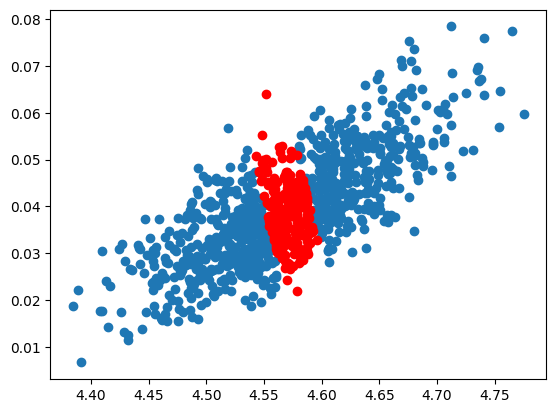

In [4]:
SA = SyntheticAnnotation(
    size_of_dataset=1000,
    number_of_datasets=1000,
    inner_sample_size=100,
    outer_sample_size=1000,
    alpha=0.1,
    beta=1000,
)
SA.run_experiment()
SA.visualise()